# Import packages

In [3]:
import pandas as pd
import numpy as np
import seaborn as sns
from matplotlib import pyplot as plt
from statsmodels.tsa.statespace import sarimax

Used for windows and folds

In [100]:
sys.path.append("../windowing_and_cv")

In [101]:
from windowing_and_cv.tscv_sliding import TimeSeriesSplitSliding
from window_generator import WindowGenerator
from sklearn.model_selection import TimeSeriesSplit

# Import data

In [4]:
import sys

In [5]:
sys.path.append('..')

In [6]:
raw_df = pd.read_csv("../data/dataset.csv", index_col=0, parse_dates=[0])
raw_df.head()

,VIX,T10Y3M,BAA10Y,DGS10,DCOILWTICO,DTWEXBGS,USEPUINDXD,WLEMUINDXD,BAMLC0A4CBBB,BAMLC0A1CAAA,BAMLC0A4CBBBEY,BAMLC0A1CAAAEY,BAMLC0A0CM,BAMLC0A0CMEY,DFII5,DFII10,T5YIE,T10YIE,EFFR,DCOILWTICO_R,DTWEXBGS_R,Mom,Mkt-RF,SMB,HML,ST_Rev,1MO,4WkBankDiscountRate,Gold,Gold_R,Bullish,Neutral,Bearish,Bullish 8-week Mov Avg,Bull-Bear Spread,Bull-Bear ratio,MA_5,MA_10,EMA_5,EMA_10,MOM_5,MOM_10,RSI_5,RSI_10,BOLUP_5,BOLDOWN_5,BOLUP_10,BOLDOWN_10,ADX_5,ADX_10
2003-01-02,25.39,2.85,3.37,4.07,69.05,100.8803,324.67,188.18,2.67,1.01,6.17,4.41,1.86,5.26,1.75,2.43,1.30,1.64,1.30,NaN,NaN,-1.60,3.14,-0.81,-0.35,2.29,1.18,1.16,343.80,NaN,0.3243,0.2973,0.3784,0.44985,-0.0541,0.85703,NaN,NaN,25.390000,25.390000,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2003-01-03,24.68,2.83,3.39,4.05,70.34,100.4474,357.74,148.90,2.64,1.01,6.14,4.41,1.85,5.25,1.75,2.43,1.28,1.62,1.12,0.702445,0.690999,-0.02,-0.11,-0.47,0.16,-0.08,1.18,1.16,344.50,0.694165,0.3243,0.2973,0.3784,0.44985,-0.0541,0.85703,NaN,NaN,24.964000,24.999500,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2003-01-06,24.91,2.88,3.38,4.09,69.37,99.9413,166.02,295.76,2.61,0.99,6.14,4.43,1.82,5.26,1.79,2.46,1.31,1.63,1.22,0.686228,0.690625,-1.87,2.13,-0.55,-0.42,0.13,1.17,1.15,351.75,0.703615,0.3243,0.2973,0.3784,0.44985,-0.0541,0.85703,NaN,NaN,24.938421,24.963522,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2003-01-07,25.13,2.85,3.39,4.04,68.28,100.3036,180.02,248.74,2.58,0.97,6.07,4.37,1.81,5.20,1.76,2.42,1.28,1.62,1.20,0.685260,0.694958,-0.90,-0.63,0.22,-0.12,0.40,1.17,1.15,349.00,0.689230,0.3243,0.2973,0.3784,0.44985,-0.0541,0.85703,NaN,NaN,25.018000,25.018369,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2003-01-08,25.53,2.81,3.35,4.00,67.74,100.1151,204.91,81.20,2.57,0.96,6.02,4.31,1.80,5.15,1.68,2.29,1.33,1.71,1.29,0.689185,0.692207,1.02,-1.34,0.06,0.56,-0.08,1.17,1.15,349.75,0.694221,0.3243,0.2973,0.3784,0.44985,-0.0541,0.85703,25.128,NaN,25.214550,25.165244,NaN,NaN,NaN,NaN,25.819722,24.436278,NaN,NaN,NaN,NaN


Check for Nans

In [7]:
raw_df.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 5217 entries, 2003-01-02 to 2022-12-30
Data columns (total 50 columns):
 #   Column                  Non-Null Count  Dtype  
---  ------                  --------------  -----  
 0   VIX                     5217 non-null   float64
 1   T10Y3M                  5217 non-null   float64
 2   BAA10Y                  5217 non-null   float64
 3   DGS10                   5217 non-null   float64
 4   DCOILWTICO              5217 non-null   float64
 5   DTWEXBGS                5217 non-null   float64
 6   USEPUINDXD              5217 non-null   float64
 7   WLEMUINDXD              5217 non-null   float64
 8   BAMLC0A4CBBB            5217 non-null   float64
 9   BAMLC0A1CAAA            5217 non-null   float64
 10  BAMLC0A4CBBBEY          5217 non-null   float64
 11  BAMLC0A1CAAAEY          5217 non-null   float64
 12  BAMLC0A0CM              5217 non-null   float64
 13  BAMLC0A0CMEY            5217 non-null   float64
 14  DFII5                 

Some of the data is returns, thus should drop first day and untransformed data

In [8]:
# Set first day to 1 + first day
df = raw_df.iloc[10:].copy()
del raw_df
df.drop(columns=["DCOILWTICO", "DTWEXBGS", "Gold"], inplace=True)

**OPTIONAL**: Change to *Business Day* frequency. Should not introduce any NaNs in index, as demonstrated below

In [9]:
(df.asfreq("B").index == df.index).all()

True

# Set up train/test split
In-sample and out-of-sample splits. The validation procedure will be done by cross-validation for the training data

## Determine split by inspecting Vix

If using `train/test`-split, it can be useful to inspect the data and corresponding splits.

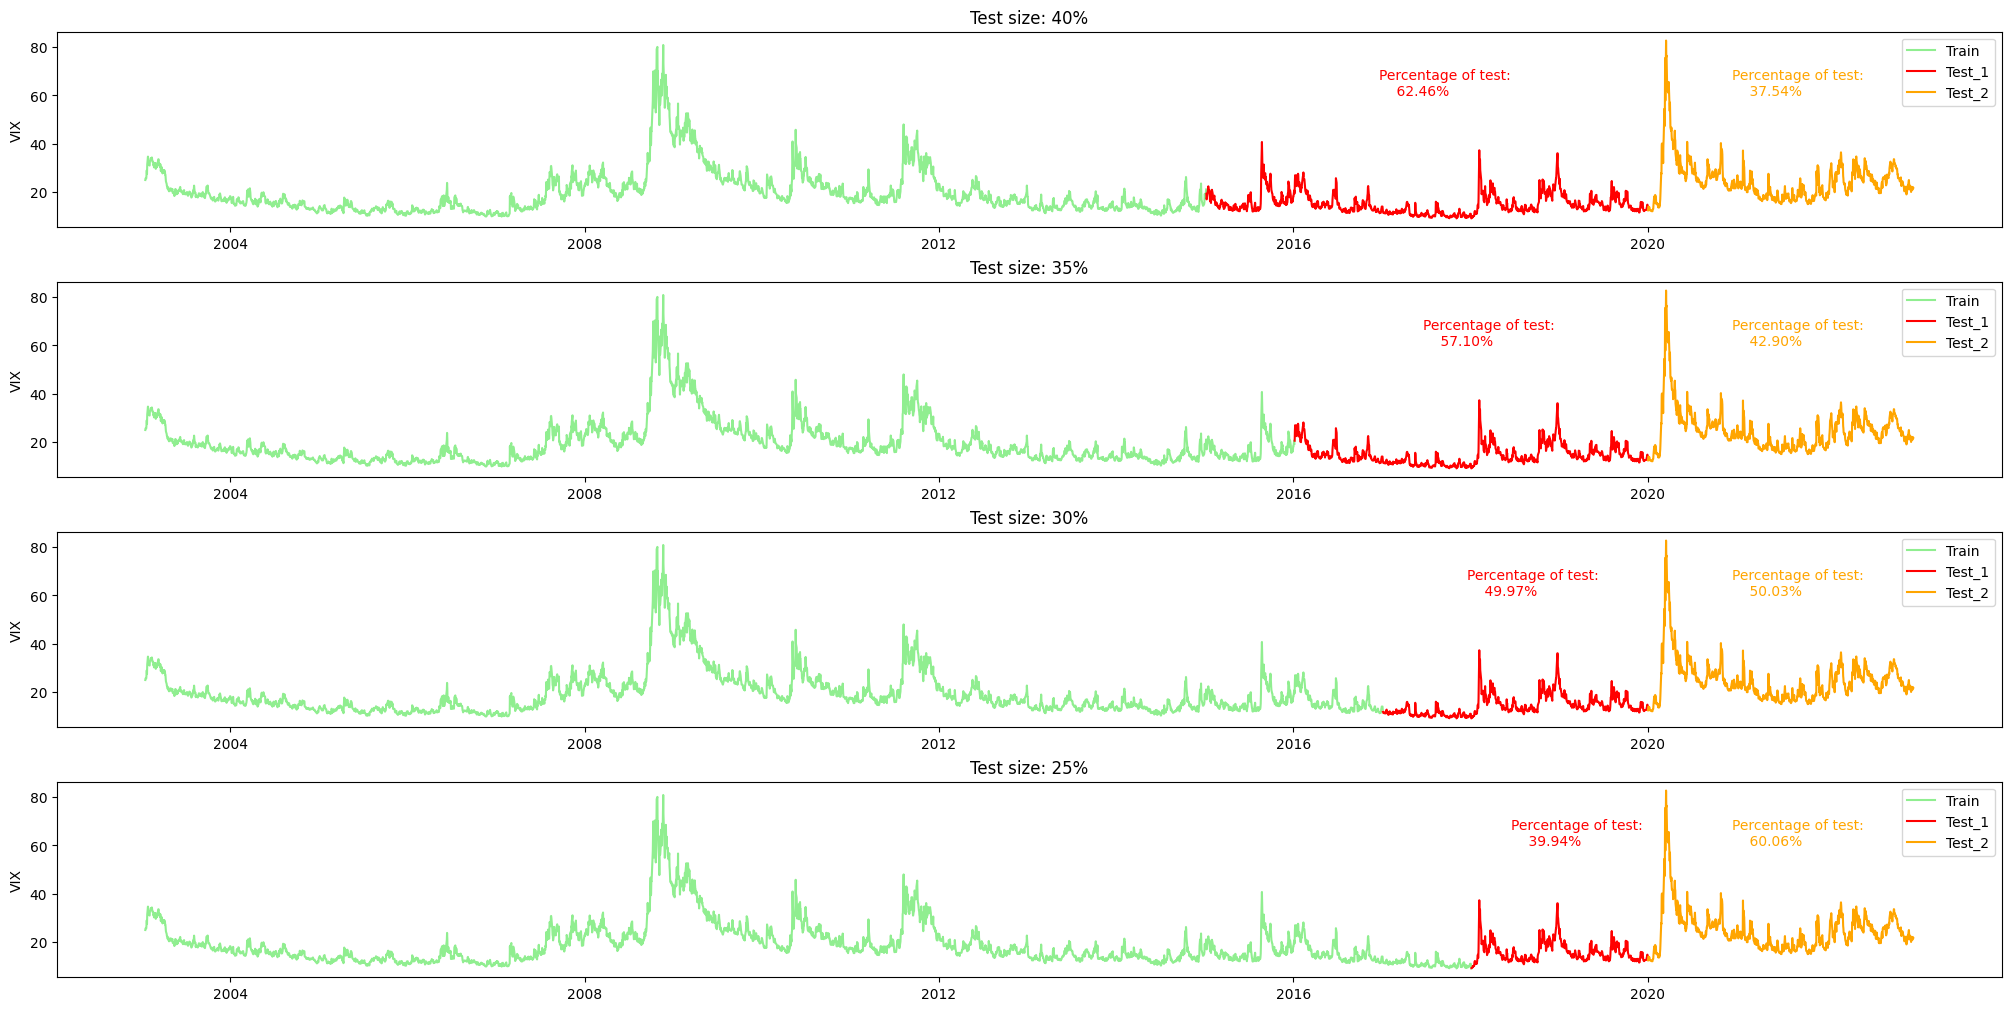

In [99]:
n = len(df)
inds = [0.6, 0.65, 0.7, 0.75]
fig, axs = plt.subplots(len(inds), 1, figsize=(20, 10), constrained_layout=True)
for ax, ind in zip(axs.ravel(), inds):
    # Create copy of frame
    temp = df.VIX.copy().to_frame()
    temp["frame"] = ""
    # Set belonging set, ie, train or test
    train_ind = int(n*ind)
    temp.iloc[:train_ind, 1] = "Train"
    # Split test into pre- and post-covid
    temp.iloc[train_ind:, 1] = "Test_1"
    temp.loc[temp.index > "2020", "frame"] = "Test_2"
    # Compute size of each group
    sizes = temp.loc[temp.frame != "Train"].frame.value_counts(normalize=True)
    size_1 = f"Percentage of test:\n    {sizes['Test_1']:0.2%}"
    size_2 = f"Percentage of test:\n    {sizes['Test_2']:0.2%}"
    # Plot 
    palette = {"Train":"lightgreen", "Validation":"purple", "Test_1":"red", "Test_2":"orange"}
    ax.set_title(f"Test size: {1-ind:.0%}")
    sns.lineplot(temp, x=temp.index, y="VIX", hue="frame", palette=palette, ax=ax)
    ax.legend(loc="upper right")
    # Annotate with each sets corresponding size
    for line in ax.get_lines():
        #print(line.get_data())
        break
    #ax.text(10000, 50, size_1, )
    x_1 = ax.get_lines()[1].get_data()[0].mean() - 200
    x_2 = ax.get_lines()[2].get_data()[0].mean() - 200
    ax.annotate(size_1,
            xy=(x_1, 60), xycoords="data", fontsize=10, color="red")
    ax.annotate(size_2,
            xy=(x_2, 60), xycoords="data", fontsize=10, color="orange")
    del temp

The better split appears to be using a test size of 30%. This allows for sufficient training data size, as well as even split between pre- and post-covid.

## Create split
Using the chosen split, split into train and test data

In [102]:
train_size = 0.7
#n = len(df)
train_ind = int(n*train_size)
train_df = df[:train_ind]
test_df = df[train_ind:]

# Folds and windows

## Creating window generator

The number of lags is chosen to be **?**

In [103]:
input_width = 5
window = WindowGenerator(
    input_width=input_width, label_width=1, shift=1, label_columns=['VIX'], 
    train_df=train_df, test_df=test_df)
window

Total window size: 6
Input indices: [0 1 2 3 4]
Label indices: [5]
Label column name(s): ['VIX']

## Converting into arrays

The following function can be used for converting tensorflow `Map Datasets` into `numpy array`

In [104]:
def create_numpy_array_from_window(train, val=None):
    """
    Returns datasets as numpy array in following order:
    train_X, train_y, val_X, val_Y
    """
    # Convert to numpy arrays
    train_X = np.concatenate([x for x, y in train], axis=0)
    train_X = train_X.reshape(len(train_X), -1)
    
    train_y = np.concatenate([y for x, y in train], axis=0)
    train_y = train_y.reshape((-1))

    if val is not None:
        val_X = np.concatenate([x for x, y in val], axis=0)
        val_X = val_X.reshape(len(val_X), -1)
    
        val_y = np.concatenate([y for x, y in val], axis=0)
        val_y = val_y.reshape((-1))
        return train_X, train_y, val_X, val_y
    else:
        return train_X, train_y

Get training data as arrays

In [108]:
x_train, y_train = create_numpy_array_from_window(window.train)
print(x_train.shape)
y_train.shape

(3639, 235)


(3639,)

In [125]:
folds = list(tp.split(x_train, y_train))

## Splitting
The following function can be used to split the data. Uses the approach described in `regression_feature_sel.ipynb` for simplified folds creation

In [244]:
def split_data(
    x_train:np.array, y_train:np.array, size=None, 
    n_splits=5, train_splits=3, test_splits=1, 
    convert_to_list=False
):
    """
    Splits the data into folds using the desired proportions.
    The folds are generator objects, thus must use convert_to_list to get as list.
    Specify the size argument to avoid using pre-constructed X and y arrays
    """
    # Create splits
    if size is not None:
        x_train = np.arange(size)
        y_train = x_train
    n_samples = len(x_train)
    tot_split = n_samples // (n_splits + 1 + train_splits + test_splits - 2)
    m_train = tot_split * train_splits
    m_test = tot_split * test_splits
    tp = TimeSeriesSplit(n_splits=5, max_train_size=m_train, test_size=m_test)
    # Get folds
    folds = tp.split(x_train, y_train)
    if convert_to_list:
        return list(folds)
    return folds

## Visualize folds
Visualize the folds according to the specified proportions

Helper function for splitting and visualizing folds. Using the approach described in `regression_feature_sel.ipynb` for simplified folds creation

In [175]:
def split_and_visualize(
    x_train:np.array, y_train:np.array, df:pd.DataFrame, train_df:pd.DataFrame, 
    n_splits=5, train_splits=3, test_splits=1, plot_all=True, target="VIX"
):
    """
    Visualize folds using the determined splitting regime.
    Use plot_all=True to plot target over entire period
    """
    # Ensure target is in both columns
    if target not in train_df.columns:
        print(target + " is not in the columns of the training dataframe")
        return
    elif target not in df.columns and plot_all:
        print(target + " is not in the overall dataframe")
        return
    
    # Create splits
    folds = split_data(x_train, y_train, n_splits, train_splits, test_splits)
    fig, axs = plt.subplots(5, figsize=(20, 10), sharex=True, sharey=True, constrained_layout=True)
    i = 0
    i_train = 0
    i_test = 0
    for fold, ax in zip(folds, axs.ravel()):
        #if i > 4:
        #    break
        train = train_df.iloc[fold[0]]
        test = train_df.iloc[fold[1]]
        print(f"Train start: {train.index[0].date()}\tTrain end: {train.index[0].date()}\tTrain size: {len(train)}")
        print(f"Test start: {test.index[0].date()}\tTest end: {test.index[-1].date()}\tTest size: {len(test)}")
        sns.lineplot(train[target], color="lightblue", ax=ax, label="Train")
        sns.lineplot(test[target], color="salmon", ax=ax, label="Validation")
        if plot_all:
            m1 = df.index < train.index[0]
            m2 = df.index > test.index[-1]
            sns.lineplot(df.loc[m1, target], color="lightgrey", ax=ax, ls=":")
            sns.lineplot(df.loc[m2, target], color="lightgrey", ax=ax, ls=":")
            ax.set_ylabel(None)
        #sns.move_legend(ax, "upper left", bbox_to_anchor=(1, 1))
        i_train += len(train)
        if i > 0:
            ax.get_legend().remove()
        i += 1
    fig.text(-0.01, 0.5, target, rotation=90, fontsize=16)
    fig.suptitle("CV Fold Visualization ", fontsize=20);

### 3:1 split(75%)

Train start: 2003-01-27	Train end: 2003-01-27	Train size: 1362
Test start: 2008-04-16	Test end: 2010-01-11	Test size: 454
Train start: 2004-10-22	Train end: 2004-10-22	Train size: 1362
Test start: 2010-01-12	Test end: 2011-10-07	Test size: 454
Train start: 2006-07-20	Train end: 2006-07-20	Train size: 1362
Test start: 2011-10-10	Test end: 2013-07-04	Test size: 454
Train start: 2008-04-16	Train end: 2008-04-16	Train size: 1362
Test start: 2013-07-05	Test end: 2015-04-01	Test size: 454
Train start: 2010-01-12	Train end: 2010-01-12	Train size: 1362
Test start: 2015-04-02	Test end: 2016-12-27	Test size: 454


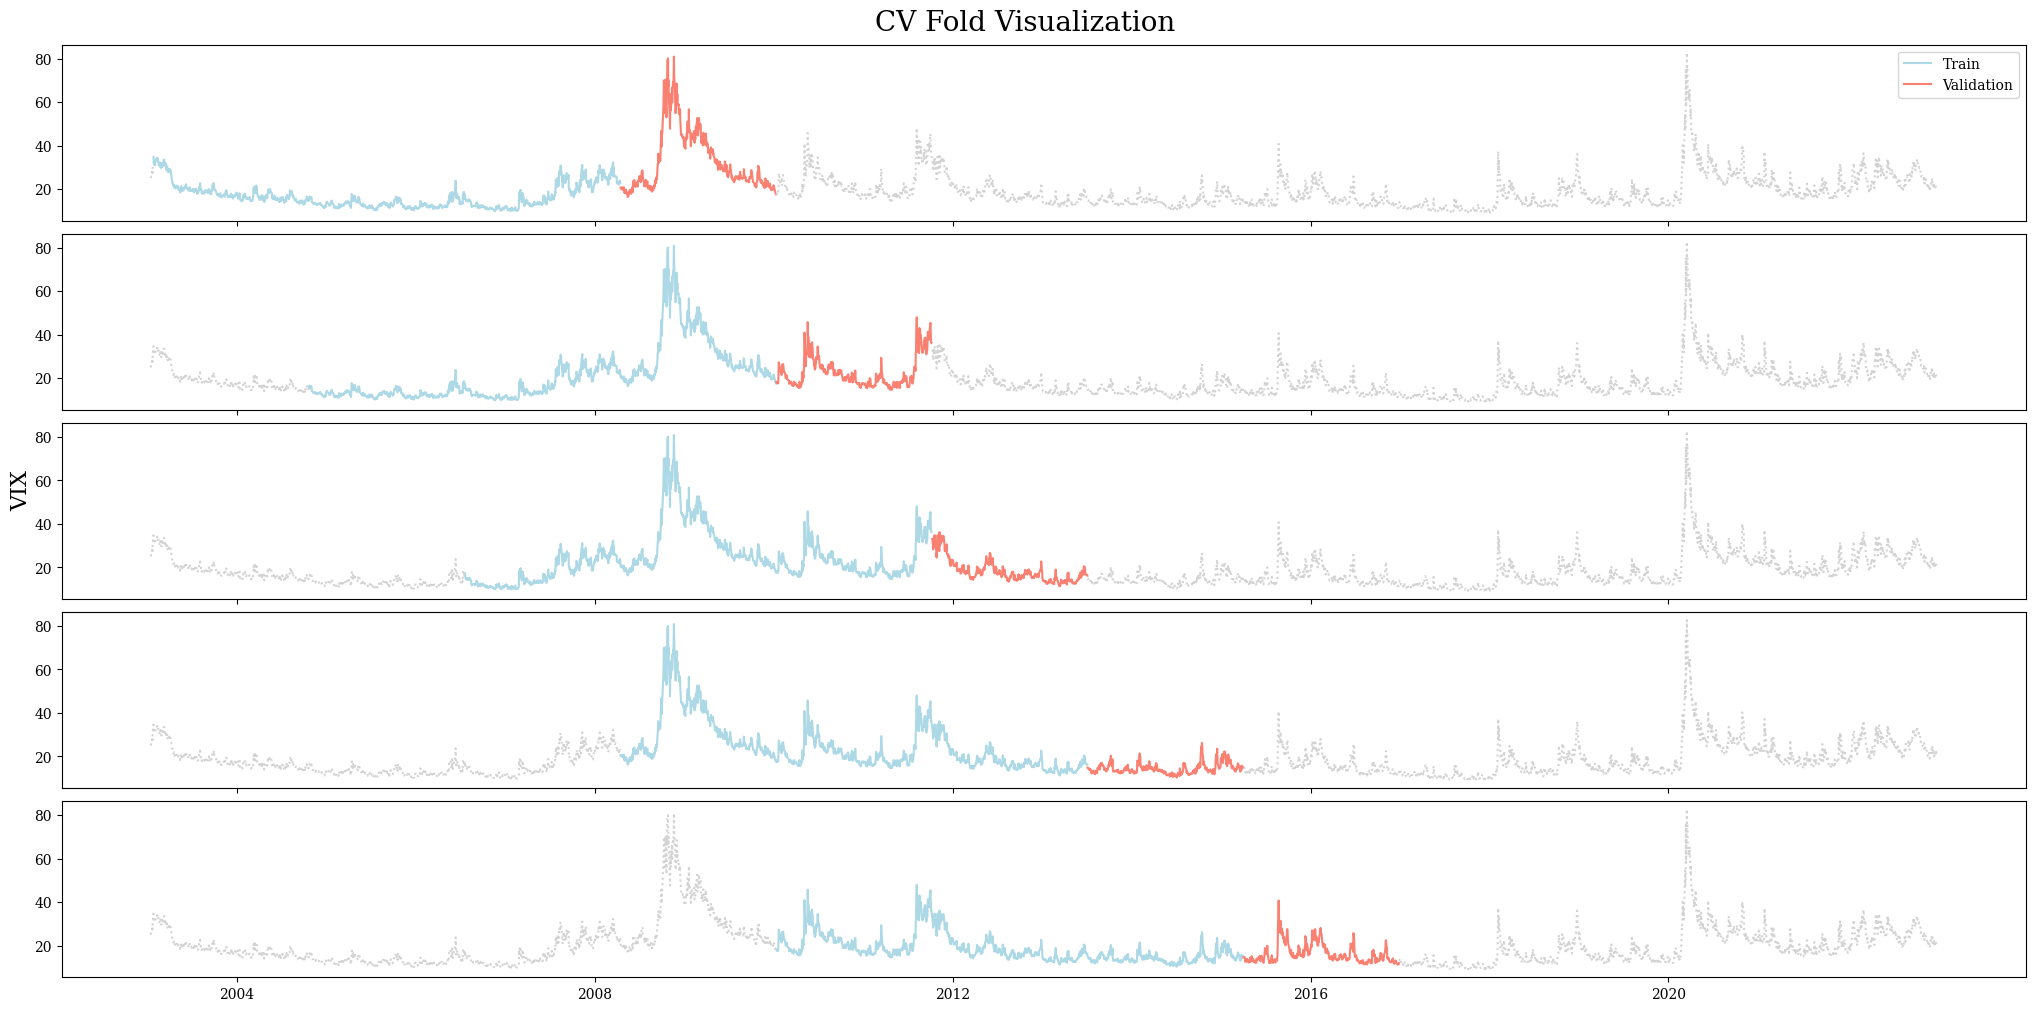

In [176]:
split_and_visualize(
    x_train=x_train, y_train=y_train,
    df=df, train_df=train_df,
    n_splits=5, train_splits=3, test_splits=1, plot_all=True, target="VIX"
)

### 2:1 split (66%)

Train start: 2003-01-24	Train end: 2003-01-24	Train size: 1038
Test start: 2007-01-17	Test end: 2009-01-12	Test size: 519
Train start: 2005-01-20	Train end: 2005-01-20	Train size: 1038
Test start: 2009-01-13	Test end: 2011-01-07	Test size: 519
Train start: 2007-01-17	Train end: 2007-01-17	Train size: 1038
Test start: 2011-01-10	Test end: 2013-01-03	Test size: 519
Train start: 2009-01-13	Train end: 2009-01-13	Train size: 1038
Test start: 2013-01-04	Test end: 2014-12-31	Test size: 519
Train start: 2011-01-10	Train end: 2011-01-10	Train size: 1038
Test start: 2015-01-01	Test end: 2016-12-27	Test size: 519


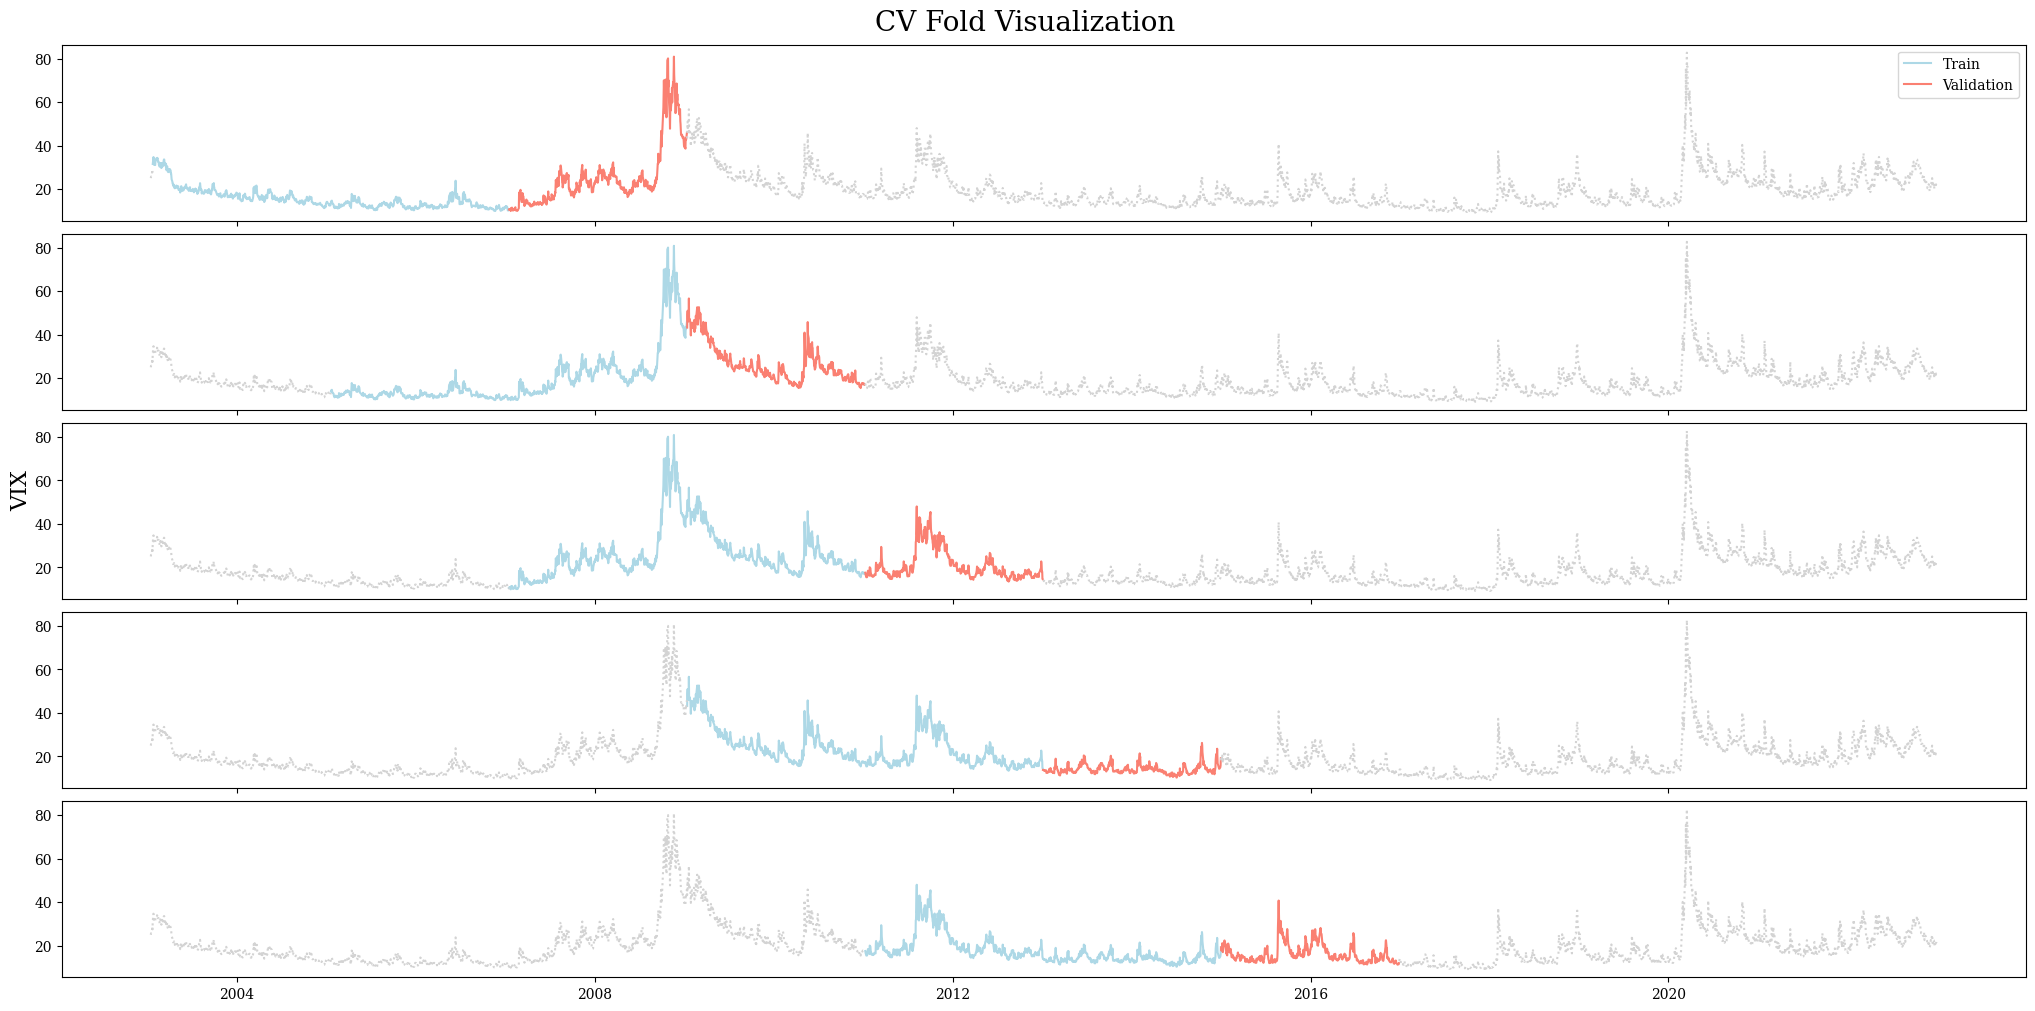

In [177]:
split_and_visualize(
    x_train=x_train, y_train=y_train,
    df=df, train_df=train_df,
    n_splits=5, train_splits=2, test_splits=1, plot_all=True, target="VIX"
)

### 4:1 split (80%)

Train start: 2003-01-21	Train end: 2003-01-21	Train size: 1616
Test start: 2009-04-01	Test end: 2010-10-18	Test size: 404
Train start: 2004-08-09	Train end: 2004-08-09	Train size: 1616
Test start: 2010-10-19	Test end: 2012-05-04	Test size: 404
Train start: 2006-02-24	Train end: 2006-02-24	Train size: 1616
Test start: 2012-05-07	Test end: 2013-11-21	Test size: 404
Train start: 2007-09-13	Train end: 2007-09-13	Train size: 1616
Test start: 2013-11-22	Test end: 2015-06-10	Test size: 404
Train start: 2009-04-01	Train end: 2009-04-01	Train size: 1616
Test start: 2015-06-11	Test end: 2016-12-27	Test size: 404


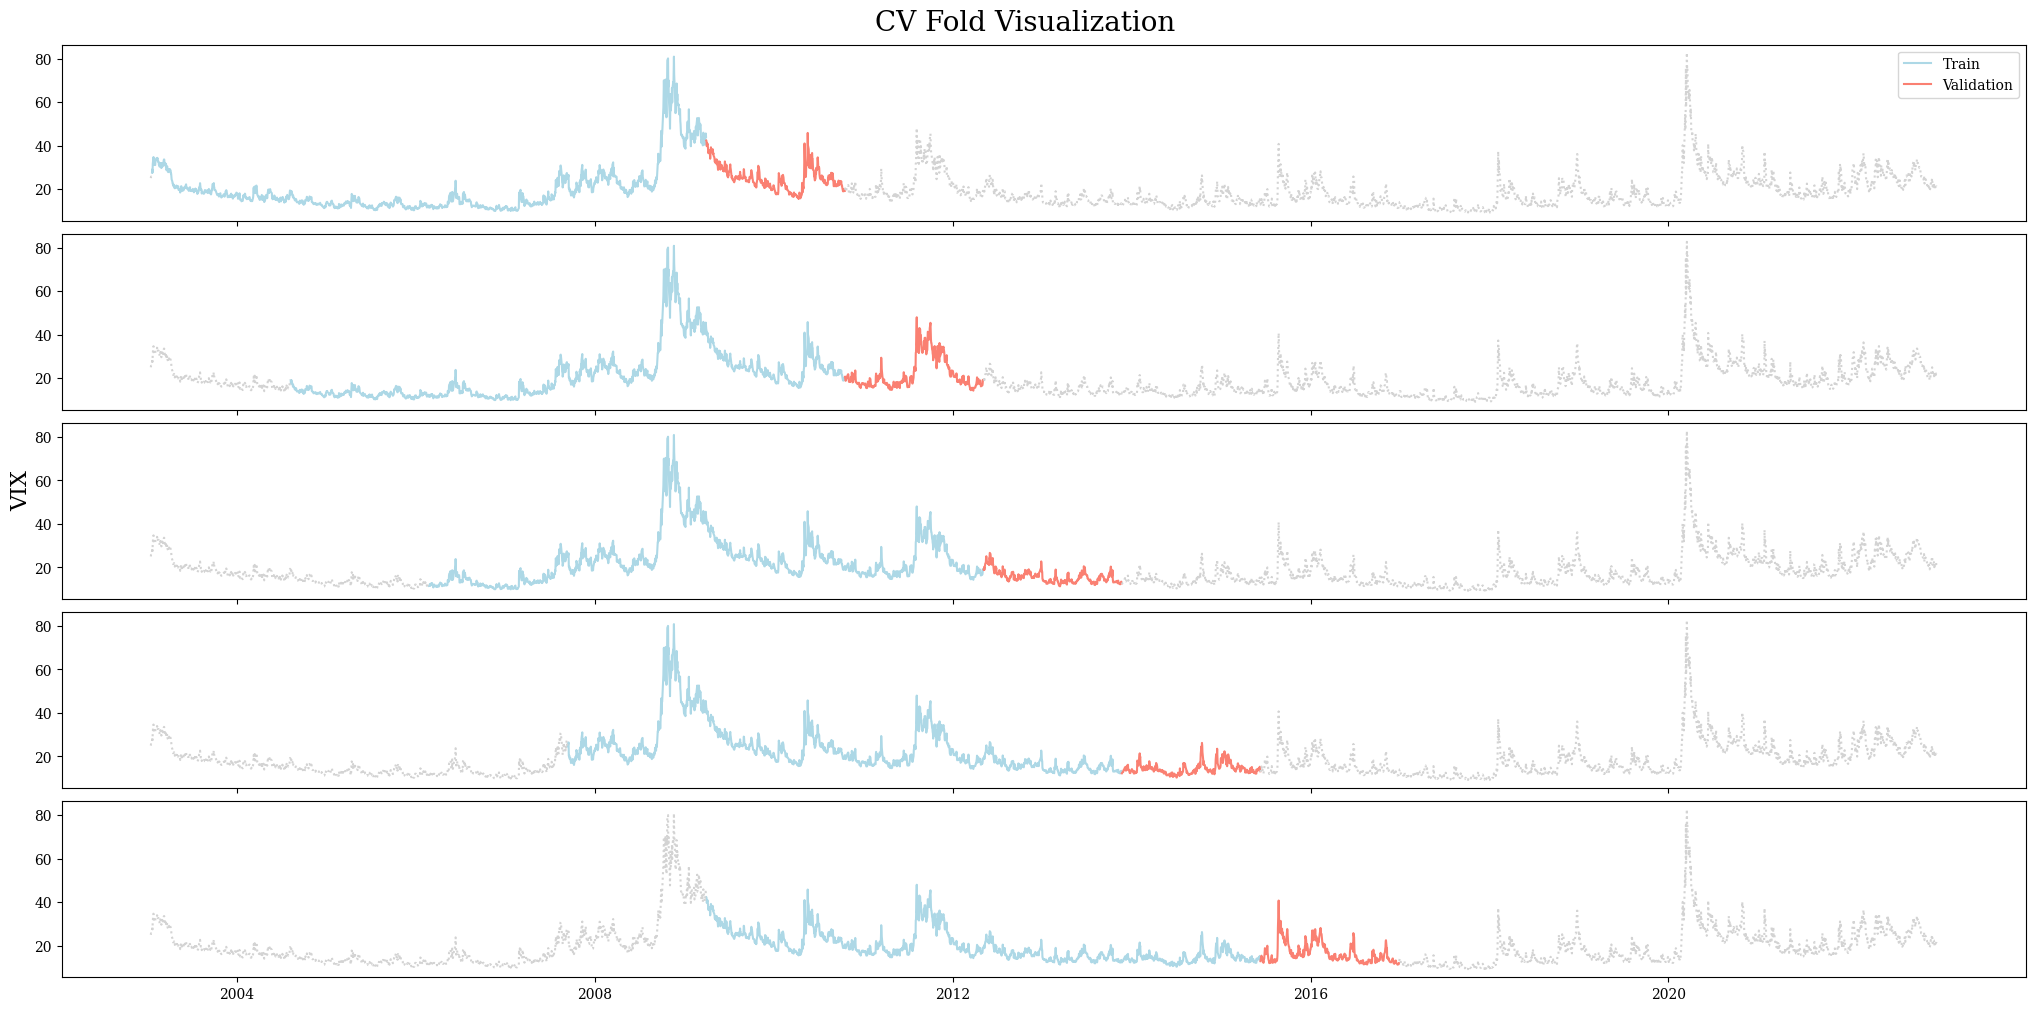

In [178]:
split_and_visualize(
    x_train=x_train, y_train=y_train,
    df=df, train_df=train_df,
    n_splits=5, train_splits=4, test_splits=1, plot_all=True, target="VIX"
)

## Summary 
To summarize, use 3:1 split

# SARIMA w/ expanding window and folds
The idea is to set the data within each fold as the traning data. Then, perform expanding window by adding one day at the time from the validation data, and refit model.

## Function for creating window data (not necessary for statsmodels)

In [188]:
def create_data(fold, train_df:pd.DataFrame, window_generator:WindowGenerator):
    # Get indices
    train_indices, val_indices = fold
    # Get data 
    train = train_df.iloc[train_indices]
    val = train_df.iloc[val_indices]
    # Scale fold
    scaler = MinMaxScaler()
    train = scaler.fit_transform(train)
    val = scaler.transform(val)
    # Make dataset using Windowgenerator
    train = window_generator.make_dataset(train)
    val = window_generator.make_dataset(val)

    # Convert to numpy arrays
    train_X = np.concatenate([x for x, y in train], axis=0)
    train_X = train_X.reshape(len(train_X), -1)
    
    train_y = np.concatenate([y for x, y in train], axis=0)
    train_y = train_y.reshape((-1))

    val_X = np.concatenate([x for x, y in val], axis=0)
    val_X = val_X.reshape(len(val_X), -1)
    
    val_y = np.concatenate([y for x, y in val], axis=0)
    val_y = val_y.reshape((-1))
    
    return train_X, train_y, val_X, val_y

## Specify metrics

In [ ]:
metrics = {
    "mse":mean_squared_error, "mae": mean_absolute_error, 
    "mape": mean_absolute_percentage_error, "r2":r2_score
}

## Specify parameters

In [ ]:
param_results  = dict(
    
)

## Create folds
Using the `size` params circumvents the need to create `X` and `y` array.

Use the default split size of 5 and 3:1 ratio

In [249]:
folds = split_data(x_train=None, y_train=None, size=len(train_df)) # Default: 5 splits, 3:1 ratio

## Perform cross-validation grid search

In [251]:
train_df

,VIX,T10Y3M,BAA10Y,DGS10,USEPUINDXD,WLEMUINDXD,BAMLC0A4CBBB,BAMLC0A1CAAA,BAMLC0A4CBBBEY,BAMLC0A1CAAAEY,BAMLC0A0CM,BAMLC0A0CMEY,DFII5,DFII10,T5YIE,T10YIE,EFFR,DCOILWTICO_R,DTWEXBGS_R,Mom,Mkt-RF,SMB,HML,ST_Rev,1MO,4WkBankDiscountRate,Gold_R,Bullish,Neutral,Bearish,Bullish 8-week Mov Avg,Bull-Bear Spread,Bull-Bear ratio,MA_5,MA_10,EMA_5,EMA_10,MOM_5,MOM_10,RSI_5,RSI_10,BOLUP_5,BOLDOWN_5,BOLUP_10,BOLDOWN_10,ADX_5,ADX_10
2003-01-16,25.01,2.92,3.29,4.10,110.03,74.28,2.51,0.93,6.03,4.35,1.74,5.16,1.71,2.31,1.40,1.79,1.24,0.695633,0.693314,1.01,-0.34,0.20,0.19,1.04,1.17,1.15,0.694997,0.291700,0.416700,0.291700,0.409925,0.000000,1.000000,24.862,24.881,24.981533,24.934141,0.76,-0.38,65.702479,46.387833,25.768797,23.955203,25.762083,23.999917,37.367072,37.367072
2003-01-17,25.70,2.87,3.29,4.05,33.84,177.68,2.53,0.92,5.99,4.28,1.75,5.12,1.60,2.25,1.45,1.80,1.20,0.695268,0.690884,1.89,-1.40,-0.44,0.63,0.66,1.17,1.15,0.699795,0.291700,0.416700,0.291700,0.409925,0.000000,1.000000,25.138,24.983,25.222882,25.087158,1.38,1.02,72.697368,59.732824,26.059889,24.216111,25.988100,23.977900,35.823926,35.823926
2003-01-20,25.70,2.87,3.29,4.05,94.97,29.33,2.53,0.92,5.99,4.27,1.75,5.11,1.60,2.25,1.45,1.80,1.20,0.693147,0.693147,1.89,-1.40,-0.44,0.63,0.66,1.17,1.15,0.693147,0.291700,0.416700,0.291700,0.409925,0.000000,1.000000,25.298,25.062,25.382743,25.207440,0.80,0.79,66.260163,57.884232,26.288495,24.307505,26.161365,23.962635,38.393169,38.393169
2003-01-21,27.59,2.82,3.31,4.01,113.03,90.31,2.53,0.96,5.96,4.28,1.75,5.09,1.62,2.23,1.38,1.78,1.31,0.698348,0.693485,0.26,-1.53,0.58,-0.43,-0.05,1.17,1.15,0.688655,0.291700,0.416700,0.291700,0.409925,0.000000,1.000000,25.902,25.308,26.121024,25.668402,3.02,2.46,87.562189,68.413174,27.871843,23.932157,27.251692,23.364308,43.073664,43.073664
2003-01-22,29.01,2.78,3.33,3.95,81.67,146.18,2.56,0.98,5.93,4.24,1.77,5.04,1.60,2.23,1.34,1.72,1.26,0.691053,0.691694,0.67,-0.94,0.42,-0.31,0.04,1.17,1.15,0.699767,0.291700,0.416700,0.291700,0.409925,0.000000,1.000000,26.602,25.656,27.086220,26.307464,3.50,3.48,88.888889,72.597403,29.909005,23.294995,28.707036,22.604964,58.532987,58.532987
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2016-12-28,12.95,1.98,2.26,2.51,161.59,46.40,1.64,0.70,3.84,3.10,1.28,3.43,0.17,0.56,1.85,1.95,0.66,0.699744,0.694323,-0.13,-0.87,-0.27,0.08,-0.02,0.48,0.47,0.694582,0.446064,0.262391,0.291545,0.419040,0.154519,1.530001,11.850,11.867,12.107089,12.039055,1.68,-0.24,100.000000,46.666667,13.169924,10.530076,13.070958,10.663042,44.202792,44.202792
2016-12-29,13.37,2.02,2.27,2.49,116.01,38.07,1.63,0.70,3.81,3.07,1.28,3.40,0.15,0.55,1.81,1.94,0.66,0.691994,0.690767,0.08,-0.04,0.15,-0.33,0.29,0.39,0.38,0.698115,0.455696,0.286920,0.257384,0.446457,0.198312,1.770491,12.238,11.925,12.528059,12.281045,1.94,0.58,100.000000,58.011050,14.005337,10.470663,13.360247,10.489753,56.704663,56.704663
2016-12-30,14.04,1.94,2.28,2.45,141.16,52.94,1.64,0.71,3.78,3.04,1.29,3.37,0.09,0.50,1.84,1.95,0.55,0.692872,0.691810,-0.26,-0.52,-0.12,0.20,-0.03,0.44,0.43,0.693147,0.455696,0.286920,0.257384,0.446457,0.198312,1.770491,12.758,12.109,13.032039,12.600855,2.60,1.84,100.000000,74.864865,14.851294,10.664706,14.074694,10.143306,67.764000,67.764000
2017-01-02,14.04,1.94,2.28,2.45,242.04,15.89,1.64,0.71,3.78,3.04,1.29,3.37,0.09,0.50,1.84,1.95,0.55,0.693147,0.693147,-0.26,-0.52,-0.12,0.20,-0.03,0.44,0.43,0.693147,0.455696,0.286920,0.257384,0.446457,0.198312,1.770491,13.278,12.342,13.368026,12.862518,2.60,2.33,100.000000,86.292835,14.991558,11.564442,14.624354,10.059646,76.599805,76.599805


In [230]:
from itertools import product

In [ ]:
# Create list of cross product of values in dictionary
param_keys = param_grid.keys()
combinations = product(*a.values())
ds = [dict(zip(param_keys, cc)) for cc in combinations]

param_results = dict()

for grid in ds:
    # TODO
    # Print current parameter specifications
    print(f"Params: {ds}")
    # Create result dictionary 
    results = {key:[] for key in metrics.keys()}
    for fold in folds:
        train_indices, val_indices = fold
        # Get data 
        train = train_df.iloc[train_indices]
        val = train_df.iloc[val_indices]
        # Scale fold
        scaler = MinMaxScaler()
        train = scaler.fit_transform(train)
        # Create model
        # TODO CREATE MODEL
        #model = ElasticNet(alpha=alpha, l1_ratio=l1_ratio) 
        #print(f"train x: {train_X.shape}\ttrain y: {train_y.shape}")
        #print(f"val x: {val_X.shape}\tval y: {val_y.shape}")

        # Fit
        model.fit(train_X, train_y)

        # Predict
        prediction = model.predict(val_X)
        for key, metric in metrics.items():
            score = metric(val_y, prediction)
            results[key].append(score)

    # Compute mean for each metric over all folds
    mean_results = {key:[] for key in metrics.keys()}
    for key, metric in results.items():
        mean_score = np.mean(metric)
        mean_results[key] = mean_score
    ds["result"] = mean_results